# Imports

In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import os
import sys
import torch
from tqdm import tqdm
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
import yaml
from dotmap import DotMap
import torchvision
# import copy
# import h5py
# import numpy as np
# import pandas as pd
from IPython.display import display
# import random
# import matplotlib.ticker as ticker
# import matplotlib.pyplot as plt
import numpy as np
# import itertools
# import sklearn


# local imports
sys.path.insert(
    0,
    os.path.join(
        os.path.dirname(os.path.abspath(''))
    )
)
from dataloaders.cifar10 import (
    load_cifar10
)
from dataloaders.cifar100 import (
    load_cifar100
)
from models import models_dict as MODELS_DICT
# models_dict = {
#     "resnet18_cifar": resnet18_cifar,
#     "resnet18_torch": torchvision.models.resnet18,
#     "resnet50_torch": torchvision.models.resnet50,
#     "densenet_cifar": densenet_cifar
# }
from utils import (
    compute_calibration_error,
    check_config_for_training_experiment,
    dataset_loss_and_accuracy,
    has_batch_norm,
    make_exps_deterministic,
    make_interpolation_plot,
    load_models,
    match_weights,
    setup_model,
    setup_optimizer,
    setup_scheduler,
    StarDomain
)
sys.path.pop(0)


SPIRALS_PATH = "./spirals.csv"

# Functions

In [115]:

def apply_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # to suppress warning
    torch.use_deterministic_algorithms(True, warn_only=True)


def extract_list_from_huge_string(huge_string):
    assert isinstance(huge_string, str)
    split = huge_string.split('\n')
    res = []
    for el in split:
        el = el.strip()
        if el != '':
            res.append(el)
    return res


def get_model_id(model_path):
    return model_path.split(os.sep)[-1].split(".")[0]


def get_link(raw_link):
    id = raw_link.split("/d/")[-1].split("/")[0]
    return f"https://drive.google.com/uc?id={id}"


def get_model(chkpt_path, model_name, model_settings={}):
    model = MODELS_DICT[model_name](**model_settings)
    model.load_state_dict(torch.load(chkpt_path)["state_dict"])
    return model


def get_resnet18_cifar(chkpt_path, num_classes=10):
    return get_model(
        chkpt_path,
        "resnet18_cifar",
        model_settings={"num_classes": num_classes}
)


def get_resnet18_cifar100(chkpt_path):
    return get_resnet18_cifar(chkpt_path, num_classes=100)


def get_paths(root_path):
    stars_path = os.path.join(root_path, "stars")
    anchors_path = os.path.join(root_path, "anchors")

    anchors = [
        os.path.join(anchors_path, name) for name in os.listdir(anchors_path)
    ]
    stars = [
        os.path.join(stars_path, name) for name in os.listdir(stars_path)
    ]
    return anchors, stars


@torch.no_grad
def compute_margin_for_batch(model, x, device="cuda:0", agg="mean", norm="l1"):

    x.requires_grad = True

    with torch.enable_grad():
        output = model(x)

    output = output.to(device)

    num_classes = output.shape[-1]
    batch_size = output.shape[0]
    used_classes = range(num_classes)

    model_grads = {}

    with torch.enable_grad():
        for i, class_i in enumerate(used_classes):
            model_grads[class_i] = get_grad(
                output[..., class_i],
                x,
                retain_graph=(i != len(used_classes) - 1)
            )

        if agg == "min_to_pred":
            margins_for_all_class_pairs = torch.ones(
                batch_size,
                num_classes,
                num_classes
            ).to(output.device) * torch.inf
        else:
            margins_for_all_class_pairs = torch.zeros(
                batch_size,
                num_classes,
                num_classes
            ).to(output.device)

        for i in range(len(used_classes)):
            for j in range(i + 1, len(used_classes)):

                class_i = used_classes[i]
                class_j = used_classes[j]

                output_i = output[..., class_i]
                output_j = output[..., class_j]

                grad_i = model_grads[class_i]
                grad_j = model_grads[class_j]
                batch_margins_for_class_pair = compute_margin(
                    output_i,
                    output_j,
                    grad_i,
                    grad_j,
                    norm=norm
                )

                # [batch_size, num_classes, num_classes],
                # (s, i, j) - margin between classes i and j for sample s
                margins_for_all_class_pairs[:, class_i, class_j] \
                    = batch_margins_for_class_pair
                margins_for_all_class_pairs[:, class_j, class_i] \
                    = batch_margins_for_class_pair

        if agg == "min_to_pred":
            pred = output.argmax(dim=-1)

            min_distances_for_all_classes = margins_for_all_class_pairs.min(dim=-1).values

            min_distances_to_pred = min_distances_for_all_classes[
                torch.arange(batch_size).to(pred.device),
                pred
            ]
            return min_distances_to_pred.mean()
        elif agg == "max_first":
            # sanity check that it is higher than min_to_pred
            res = margins_for_all_class_pairs.max(dim=-1).values.max(-1).values.mean()
            return res
        else:
            res = margins_for_all_class_pairs.mean(dim=0)
            if agg == "mean":
                # diagonal for class_i == class_j has only zeros,
                # so we don't need to use them in mean computation
                return res.mean() * (num_classes / (num_classes - 1))
            else:
                assert agg == "max"
                return res.max()


def get_grad(output_i, x, retain_graph):
    assert x.requires_grad == True
    differentiable_value = output_i.sum()
    differentiable_value.backward(inputs=x, retain_graph=retain_graph)
    grad = x.grad
    x.grad = None
    return grad


def compute_margin(output_i, output_j, grad_i, grad_j, norm="l1"):
    # eq. 7 here: https://proceedings.neurips.cc/paper_files/paper/2018/file/42998cf32d552343bc8e460416382dca-Paper.pdf
    # d = |f_i(x) - f_j(x)| / |grad_x f_i(x) - grad_x f_j (x)|_q
    outputs_diff = (output_i - output_j).abs()
    grads_diff = (grad_i - grad_j)
    if norm == "l1":
        return (
                outputs_diff
            /
                grads_diff.abs().sum()
        )
    elif norm == "l2":
        return (
                outputs_diff
            /
                # grads_diff.abs().pow(2).sum().sqrt()
                torch.linalg.vector_norm(grads_diff, ord=2)
        )
    else:
        raise NotImplementedError("Only L1 norm is supported")


def margin_on_dataloader(
    model,
    dataloader,
    percent=0.01,
    device="cuda:0",
    agg="mean",
    norm="l1",
    random_seed=42
):

    model.eval()
    model.to(device)

    dataloader_len = len(dataloader)
    if percent == 1:
        active_batches = list(range(dataloader_len))
    else:
        total_batches = int(percent * dataloader_len)
        active_batches = np.linspace(0, dataloader_len, total_batches)
        active_batches = active_batches.astype(int)

    res = []
    pb = tqdm(total=dataloader_len, desc='batch', position=0)
    apply_random_seed(random_seed)
    for i, batch in (enumerate(dataloader)):
        pb.update(1)
        if i not in active_batches:
            continue
        x, y = batch
        x = x.to(device)
        batch_margin = compute_margin_for_batch(
            model,
            x,
            device=device,
            agg=agg,
            norm=norm
        )
        res.append(batch_margin)
    return torch.Tensor(res).mean().item()


def compute_results(
    model_paths,
    dataloader,
    cache_path,
    split_name,
    percent=1,
    load_model=get_resnet18_cifar,
    recompute_substring=None,
    agg="mean",
    norm="l1"
):
    res = {}
    if os.path.exists(cache_path):
        print(f"Loading existing results from {cache_path}")
        res = torch.load(cache_path)
    else:
        res = {}

    dataset_root = dataloader.dataset.dataset.__dict__["root"]
    dataset_name = dataset_root.split(os.sep)[-1]
    for model_path in model_paths:

        path_split = model_path.split(os.sep)[-2:]
        assert len(path_split) == 2
        model_type = path_split[0]
        if model_type == '.':
            model_type = path_split[1].split("_")[0]
            if "anchor" in model_type:
                model_type = "anchor"
            else:
                assert "star" in model_type
                model_type = "star"
        model_id = path_split[1].split(".")[0]
        df_id = f"{model_type}_{model_id}_{dataset_name}_p{percent}"
        to_recompute = (not df_id in res)
        if not to_recompute and recompute_substring is not None:
            to_recompute = recompute_substring in df_id

        if to_recompute:
            print(f"Computing results for {df_id}")
            res[df_id] = {}
            res[df_id]["margin"] = margin_on_dataloader(
                load_model(model_path),
                dataloader,
                percent=percent,
                device="cuda:0",
                agg=agg,
                norm=norm
            )
            res[df_id]["model_type"] = model_type
            res[df_id]["dataset_name"] = dataset_name
            res[df_id]["percent"] = percent
            res[df_id]["model_id"] = model_id
            res[df_id]["split_name"] = split_name
        else:
            print(f"Reusing results for {df_id}")
    torch.save(res, cache_path)
    return res


def plot_dict(
    res,
    to_show=True,
    filter_dict={},
    drop_columns=[],
    group_aggregate_list=[],
    query=None
):

    df = pd.DataFrame.from_dict(res, orient='index')

    for column_name, allowed_values in filter_dict.items():
        df = df[df[column_name] in allowed_values]

    if query is not None:
        df = df.query(query)

    for column_name in drop_columns:
        if column_name == "index":
            df.reset_index(drop=True, inplace=True)
        else:
            df = df.drop(column_name, axis=1)

    for new_index in group_aggregate_list:
        df = df.groupby(new_index).agg([(f'mean', 'mean'), (f'std', 'std')])

    if to_show:
        display(df)
    return df


def read_yaml(yaml_path):
    with open(yaml_path, "r") as f:
        config = yaml.safe_load(f)
    return config


def make_config(config_path):
    config = read_yaml(config_path)
    config = DotMap(config)
    return config


def training_experiment(model, model_id, config, train_dl, val_dl, test_dl):

    # setup data and model
    # train_dl, val_dl, test_dl = datasets_dict[config.dataset.name](**config.dataset.settings)
    # model = setup_model(config)
    apply_random_seed(config.params.random_seed)
    optimizer = setup_optimizer(model, config)
    scheduler = setup_scheduler(optimizer, config)
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=config.training.label_smoothing)
    loss_fn_eval = torch.nn.CrossEntropyLoss()

    if config.exp_type in ["train_star"]:
        star_domain = StarDomain(model, config, train_dl)

    step = 0

    val_loss, val_accuracy = dataset_loss_and_accuracy(
        model=model, dl=val_dl, loss_fn=loss_fn_eval
    )
    print(f"before training, val loss: {val_loss}, val accuracy: {val_accuracy}")

    for epoch in tqdm(range(config.training.num_epochs)):

        model.train()
        if config.exp_type in ["train_star"] and config.model.permute_anchors:
            star_domain.align_anchors_with_star()

        train_loss = 0
        train_accuracy = 0
        # pb = tqdm(total=len(train_dl), desc='batch', position=0)
        for i, batch in enumerate(train_dl):
            # pb.update(1)

            step += 1
            # if config.dataset.name == "imagenet1k":
            #     if i % 100 == 0:
            #         print(f"epoch {epoch} step {step}")
            optimizer.zero_grad(set_to_none=True)

            y_backup = batch[1].clone().cuda() # for calculating training accuracy
            # main training operations
            x, y = batch
            x = x.cuda()
            y = y.cuda()
            if config.exp_type in ["train_star"]:
                loss, out = star_domain.populate_star_model_gradients(
                    batch,
                    loss_fn,
                    config.training.mu_star
                )
            else:
                out = model(x)
                loss = loss_fn(out, y)
                loss.backward()

            if config.training.use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.grad_clip_norm)

            optimizer.step()
            loss.detach()
            train_loss += loss.item()
            accuracy_tmp = torch.sum(torch.argmax(out, axis=1) == y_backup) / len(y_backup)
            train_accuracy += accuracy_tmp.item()

            del x, y, out, batch

        scheduler.step()

        # if training a star model and using batch norm, recalculate batch stats
        if config.exp_type in ["train_star"] and has_batch_norm(model):
            star_domain.recalculate_batch_statistics(train_dl)

        # log epoch results

        epoch_results = {}
        val_loss, val_accuracy = dataset_loss_and_accuracy(
            model=model, dl=val_dl, loss_fn=loss_fn_eval
        )

        epoch_results["val_accuracy"] = val_accuracy
        epoch_results["val_loss"] = val_loss
        epoch_results["train_loss"] = train_loss / len(train_dl)
        epoch_results["train_accuracy"] = train_accuracy / len(train_dl)
        epoch_results["lr"] = [param_group["lr"] for param_group in optimizer.param_groups][0]

        # for _ in range(10):
        #     try:
        #         wandb_run.log(epoch_results)
        #         break
        #     except:
        #         print("wandb logging failed, trying again")
        #         time.sleep(5)

    # save model weights
    ckpt_file = f"{model_id}_checkpoint{epoch}.pt"

    state_dict = model.state_dict()
    if config.training.parallel:
        state_dict = {k[7:]: v for k, v in state_dict.items()}
    torch.save({"state_dict": state_dict}, ckpt_file)

    # calculate test loss and accuracy
    test_loss, test_accuracy = dataset_loss_and_accuracy(
        model=model, dl=test_dl, loss_fn=loss_fn_eval
    )

    # log everything in csv
    csv_results = []
    csv_results.append(["val_accuracy", f"{val_accuracy:.5f}"])
    csv_results.append(["val_loss", f"{val_loss:.3f}"])
    csv_results.append(["train_loss", f"{train_loss / len(train_dl):.3f}"])
    csv_results.append(["train_accuracy", f"{train_accuracy / len(train_dl):.5f}"])
    csv_results.append(["test_accuracy", f"{test_accuracy:.5f}"])
    csv_results.append(["test_loss", f"{test_loss:.3f}"])

    # also interpolate against held-out models
    loss_barriers, acc_barriers = None, None
    if config.exp_type == "train_star" and not config.skip_computing_barriers:

        # barriers with training anchors
        loss_barriers = []
        acc_barriers = []

        # randomly choose 5 anchors, if the total number of anchors is > 5
        # otherwise, use all anchors
        # if config.dataset.name == "imagenet1k":
        #     num_training_anchors = 2
        # else:
        num_training_anchors = 5
        indices = torch.randperm(len(star_domain.anchor_models)).tolist()
        if len(star_domain.anchor_models) > num_training_anchors:
            indices = indices[:num_training_anchors]

        for i in indices:
            anchor_model = star_domain.anchor_models[i]
            if config.model.permute_anchors:
                anchor_model = match_weights(
                    model1=model,
                    model2=anchor_model,
                    train_dl=train_dl,
                    recalculate_batch_statistics=True
                )
            loss_barrier, acc_barrier = make_interpolation_plot(
                model1=model,
                model2=anchor_model,
                dl=test_dl,
                num_points=config.interpolation.num_points,
                logger=None,
                plot_title=f"star-training-anchor-{i}",
                loss_fn=loss_fn_eval,
                train_dl=train_dl
            )
            loss_barriers.append(loss_barrier)
            acc_barriers.append(acc_barrier)

    return csv_results, loss_barriers, acc_barriers

    # # barriers with held-out anchors
    # if (config.eval.held_out_anchors or config.eval.held_out_model_paths) and not config.skip_computing_barriers:
    #     loss_barriers = []
    #     acc_barriers = []
    #     held_out_anchors = load_models(config, model, "held_out")

    #     for i, anchor_model in enumerate(held_out_anchors):
    #         if config.model.permute_anchors:
    #             anchor_model = match_weights(
    #                 model1=model,
    #                 model2=anchor_model,
    #                 train_dl=train_dl,
    #                 recalculate_batch_statistics=True
    #             )
    #         loss_barrier, acc_barrier = make_interpolation_plot(
    #             model1=model,
    #             model2=anchor_model,
    #             dl=test_dl,
    #             num_points=config.interpolation.num_points,
    #             logger=logger,
    #             plot_title=f"interp_with_held_out-{i}",
    #             loss_fn=loss_fn_eval,
    #             train_dl=train_dl
    #         )
    #         loss_barriers.append(loss_barrier)
    #         acc_barriers.append(acc_barrier)


class MLP(torch.nn.Module):

    def __init__(
        self,
        in_channels,
        hidden_channels,
        activation_layer
    ):

        assert len(hidden_channels) > 0
        super().__init__()
        self.mlp = torchvision.ops.MLP(
            in_channels,
            hidden_channels,
            activation_layer=activation_layer
        )
        self.in_features = in_channels
        self.out_features = hidden_channels[-1]
        if self.out_features == 1:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None

    def forward(self, x):
        logits = self.mlp(x.view(x.shape[0], -1))
        if self.sigmoid is None:
            probs = logits
        else:
            probs = self.sigmoid(logits)
        return probs


def make_mlp(
    in_channels,
    hidden_channels,
    activation_layer=torch.nn.modules.activation.LeakyReLU
):
    return MLP(
        in_channels,
        hidden_channels,
        activation_layer
    )


def patch_config(config, n_epochs, random_seed):
    config.training.num_epochs = n_epochs
    config.params.random_seed = random_seed


def train_anchor(
    train_loader,
    val_loader,
    test_loader,
    model_id,
    n_epochs=200,
    random_seed=42
):
    model = make_mlp(2, [128, 2])
    config = make_config("./anchor_config.yaml")
    # config.training.num_epochs = n_epochs
    patch_config(config, n_epochs, random_seed)
    csv_results, loss_barriers, acc_barriers = training_experiment(
        model,
        model_id,
        config,
        train_loader,
        val_loader,
        test_loader
    )
    print(csv_results)


def train_star(
    train_loader,
    val_loader,
    test_loader,
    model_id,
    anchor_model_paths,
    n_epochs=200,
    random_seed=42
):
    model = make_mlp(2, [128, 2])
    config = make_config("./star_config.yaml")
    # config.training.num_epochs = n_epochs
    # config.params.random_seed = random_seed
    patch_config(config, n_epochs, random_seed)
    config.model.anchor_model_paths = anchor_model_paths
    csv_results, loss_barriers, acc_barriers = training_experiment(
        model,
        model_id,
        config,
        train_loader,
        val_loader,
        test_loader
    )
    print(csv_results)
    print(loss_barriers)
    print(acc_barriers)


def load_mlp(path):
    base_model = make_mlp(2, [128, 2])
    state_dict = torch.load(path)["state_dict"]
    base_model.load_state_dict(state_dict)
    return base_model


# Define a custom dataset
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.root = "spirals"

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Sample data
def make_dataloaders_from_df(csv_path, train_val_split=[0.7, 0.2], **dataloader_kwargs):
    df = pd.read_csv(csv_path)
    # Load data into DataFrame
    # df = pd.read_csv(StringIO(data))

    # Convert DataFrame to PyTorch tensors
    X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float32)
    y = torch.tensor(df['y'].values, dtype=torch.int64)

    # Create a dataset
    full_dataset = MyDataset(X, y)

    # Split the dataset
    train_size, val_size = train_val_split
    train_size = int(train_size * len(full_dataset))
    val_size = int(val_size * len(full_dataset))
    test_size = len(full_dataset) - (train_size + val_size)
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size]
    )

    # Create DataLoader for each set
    assert "shuffle" not in dataloader_kwargs
    train_loader = DataLoader(train_dataset, shuffle=True, **dataloader_kwargs)
    val_loader = DataLoader(val_dataset, shuffle=False, **dataloader_kwargs)
    test_loader = DataLoader(test_dataset, shuffle=False, **dataloader_kwargs)

    return train_loader, val_loader, test_loader

# Prepare synthetic

In [13]:
csv_path = "./spirals.csv"

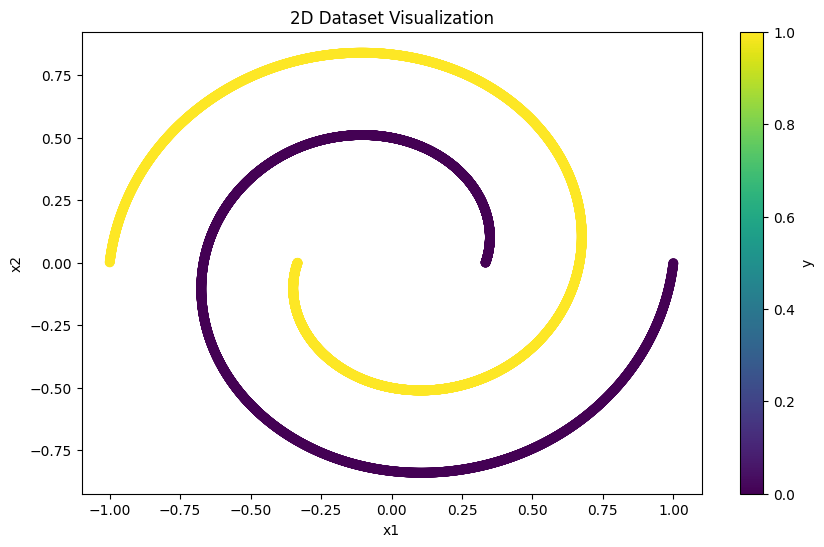

In [106]:
import matplotlib.pyplot as plt

# from io import StringIO
df = pd.read_csv(SPIRALS_PATH)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['x1'], df['x2'], c=df['y'], cmap='viridis')
plt.title('2D Dataset Visualization')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(scatter, label='y')
plt.show()

In [107]:
spiral_train_loader, spiral_val_loader, spiral_test_loader = make_dataloaders_from_df(SPIRALS_PATH, batch_size=128)

## Train anchor

In [109]:
num_anchors = 15
for i in range(num_anchors):
    train_anchor(
        spiral_train_loader,
        spiral_val_loader,
        spiral_test_loader,
        model_id=f"anchor{i}",
        n_epochs=200,
        random_seed=i
    )

before training, val loss: 0.6892554993629456, val accuracy: 0.537


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6974906930923462, val accuracy: 0.416


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.7016787433624267, val accuracy: 0.4985


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6933593950271606, val accuracy: 0.4385


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6925903005599976, val accuracy: 0.501


100%|██████████| 200/200 [00:29<00:00,  6.68it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.026'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.7018554406166077, val accuracy: 0.58


100%|██████████| 200/200 [00:30<00:00,  6.56it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.711228563785553, val accuracy: 0.4985


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.7260764827728271, val accuracy: 0.4985


100%|██████████| 200/200 [00:30<00:00,  6.53it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6915454759597778, val accuracy: 0.542


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.718302101135254, val accuracy: 0.5015


100%|██████████| 200/200 [00:30<00:00,  6.56it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.706251811504364, val accuracy: 0.4985


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.7077323770523072, val accuracy: 0.4985


100%|██████████| 200/200 [00:30<00:00,  6.55it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.026'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6954874997138977, val accuracy: 0.575


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6960453243255615, val accuracy: 0.5015


100%|██████████| 200/200 [00:30<00:00,  6.50it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]
before training, val loss: 0.6932215046882629, val accuracy: 0.5015


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]

[['val_accuracy', '1.00000'], ['val_loss', '0.025'], ['train_loss', '0.024'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.025']]


## Barriers between anchors

In [123]:
num_anchors = 15

loss_barriers = {}
acc_barriers = {}

for i in tqdm(range(num_anchors)):
    for j in range(num_anchors):
        loss_barrier, acc_barrier = make_interpolation_plot(
            model1=load_mlp(f"anchor{j}_checkpoint199.pt"),
            model2=load_mlp(f"anchor{i}_checkpoint199.pt"),
            dl=spiral_test_loader,
            num_points=21,
            logger=None,
            plot_title=f"star-training-anchor-{i}",
            loss_fn=torch.nn.CrossEntropyLoss(),
            train_dl=spiral_train_loader
        )
        loss_barriers[f"{i}->{j}"] = loss_barrier
        acc_barriers[f"{i}->{j}"] = acc_barrier


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:59<00:00,  3.98s/it]


In [125]:
print(loss_barriers)
print(acc_barriers)

print(np.mean(np.array(list(loss_barriers.values()))))
print(np.mean(np.array(list(acc_barriers.values()))))

{'0->0': 3.4868717184444176e-09, '0->1': 0.4099312331920808, '0->2': 0.3120058842375874, '0->3': 0.28455002541392177, '0->4': 0.38993182227015494, '0->5': 0.4842320231933698, '0->6': 0.22095285189151764, '0->7': 0.3757899135574699, '0->8': 0.3079405860975385, '0->9': 0.533106282018125, '0->10': 0.30042626629449587, '0->11': 0.4667473162249529, '0->12': 0.39309149270465205, '0->13': 1.0910870441666112, '0->14': 0.3430723179800518, '1->0': 0.4099312346228497, '1->1': 5.3048133871747005e-09, '1->2': 0.2816034970257747, '1->3': 0.4696290697157383, '1->4': 0.33927679958194495, '1->5': 0.3378772236704826, '1->6': 0.24770898163854294, '1->7': 0.6427723792344332, '1->8': 0.39800839537382127, '1->9': 0.37568239506993695, '1->10': 0.37397311083227397, '1->11': 0.5919486709162594, '1->12': 0.34990671885207886, '1->13': 0.37157639899104833, '1->14': 0.2792761719822884, '2->0': 0.3120058842375874, '2->1': 0.28160353373659536, '2->2': 6.407499312383047e-09, '2->3': 0.3572405496537685, '2->4': 0.3279

## Train star

In [111]:
for i, anchor_paths in enumerate(
    [
        "./anchor_paths",
        "./anchor_paths1",
        "./anchor_paths2"
    ]
):
    train_star(
        spiral_train_loader,
        spiral_val_loader,
        spiral_test_loader,
        model_id=f"star{i}",
        anchor_model_paths=anchor_paths,
        n_epochs=200,
        random_seed=i
    )

Loading anchor models from file paths... ./anchor_paths
Loading model from file path: ./anchor0_checkpoint199.pt

Loading model from file path: ./anchor1_checkpoint199.pt

Loading model from file path: ./anchor2_checkpoint199.pt

Loading model from file path: ./anchor3_checkpoint199.pt

Loading model from file path: ./anchor4_checkpoint199.pt

before training, val loss: 0.7019916357994079, val accuracy: 0.485


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.038'], ['train_loss', '0.067'], ['train_accuracy', '1.00000'], ['test_accuracy', '1.00000'], ['test_loss', '0.038']]
[0.07802985127270223, 0.07334502390772105, 0.07220073034614324, 0.07288520359660312, 0.06299206291139126]
[-0.006000000000000005, -0.0030000000000000027, -0.0040000000000000036, -0.007000000000000006, 0.0]
Loading anchor models from file paths... ./anchor_paths1
Loading model from file path: ./anchor5_checkpoint199.pt

Loading model from file path: ./anchor6_checkpoint199.pt

Loading model from file path: ./anchor7_checkpoint199.pt

Loading model from file path: ./anchor8_checkpoint199.pt

Loading model from file path: ./anchor9_checkpoint199.pt

before training, val loss: 0.695944797039032, val accuracy: 0.5015


100%|██████████| 200/200 [00:36<00:00,  5.46it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.039'], ['train_loss', '0.068'], ['train_accuracy', '0.99957'], ['test_accuracy', '1.00000'], ['test_loss', '0.039']]
[0.07072013159841299, 0.08609194019436836, 0.066719667121768, 0.06359599839150906, 0.06231738564372063]
[-0.0050000000000000044, -0.0030000000000000027, -0.0030000000000000027, -0.0040000000000000036, -0.0030000000000000027]
Loading anchor models from file paths... ./anchor_paths2
Loading model from file path: ./anchor10_checkpoint199.pt

Loading model from file path: ./anchor11_checkpoint199.pt

Loading model from file path: ./anchor12_checkpoint199.pt

Loading model from file path: ./anchor13_checkpoint199.pt

Loading model from file path: ./anchor14_checkpoint199.pt

before training, val loss: 0.7227356996536255, val accuracy: 0.4985


100%|██████████| 200/200 [00:35<00:00,  5.61it/s]


[['val_accuracy', '1.00000'], ['val_loss', '0.039'], ['train_loss', '0.070'], ['train_accuracy', '0.99957'], ['test_accuracy', '1.00000'], ['test_loss', '0.039']]
[0.07832759683502453, 0.05844041902571917, 0.07408886510133743, 0.06742444214969873, 0.07472733630954556]
[-0.008000000000000007, -0.0020000000000000018, -0.0020000000000000018, -0.0010000000000000009, -0.0040000000000000036]


In [126]:
star_barriers = [0.07072013159841299, 0.08609194019436836, 0.066719667121768, 0.06359599839150906, 0.06231738564372063] + [0.07072013159841299, 0.08609194019436836, 0.066719667121768, 0.06359599839150906, 0.06231738564372063] + [0.07832759683502453, 0.05844041902571917, 0.07408886510133743, 0.06742444214969873, 0.07472733630954556]

In [127]:
print(np.mean(np.array(star_barriers)))

0.07012659368805889


In [61]:
train_loader, val_loader, test_loader = make_dataloaders_from_df(SPIRALS_PATH, batch_size=128)

loss_barrier, acc_barrier = make_interpolation_plot(
    model1=load_mlp("anchor0_checkpoint199.pt"),
    model2=load_mlp("anchor1_checkpoint199.pt"),
    dl=test_loader,
    num_points=21,
    logger=None,
    plot_title=f"star-training-anchor-{i}",
    loss_fn=torch.nn.CrossEntropyLoss(),
    train_dl=train_loader
)

print(loss_barrier)
print(acc_barrier)

In [62]:
print(loss_barrier)
print(acc_barrier)

1.0156645817716026e-05
0.0


In [69]:
train_loader, val_loader, test_loader = make_dataloaders_from_df(SPIRALS_PATH, batch_size=128)

loss_barrier, acc_barrier = make_interpolation_plot(
    model1=load_mlp("anchor0_checkpoint199.pt"),
    model2=load_mlp("anchor4_checkpoint199.pt"),
    dl=test_loader,
    num_points=21,
    logger=None,
    plot_title=f"star-training-anchor-{i}",
    loss_fn=torch.nn.CrossEntropyLoss(),
    train_dl=train_loader
)

print(loss_barrier)
print(acc_barrier)

0.5033825747668743
-0.24550000011920936


# Prepare cifar100

In [177]:
get_link("https://drive.google.com/file/d/1zTH5_YBM9h4AYfeQWhkJyqXW_14xS38B/view?usp=drive_link")

'https://drive.google.com/uc?id=1zTH5_YBM9h4AYfeQWhkJyqXW_14xS38B'

In [178]:
!gdown https://drive.google.com/uc?id=1zTH5_YBM9h4AYfeQWhkJyqXW_14xS38B

Downloading...
From (original): https://drive.google.com/uc?id=1zTH5_YBM9h4AYfeQWhkJyqXW_14xS38B
From (redirected): https://drive.google.com/uc?id=1zTH5_YBM9h4AYfeQWhkJyqXW_14xS38B&confirm=t&uuid=51724791-d6b0-4e41-9a83-bae8a9e60ecc
To: /scratch_local/arubinstein17-163577/starlight/notebooks/cifar100_resnet18.zip
100%|██████████████████████████████████████| 4.38G/4.38G [00:57<00:00, 76.1MB/s]


In [182]:
!unzip cifar100_resnet18.zip -d ./

Archive:  cifar100_resnet18.zip
   creating: ./cifar100_resnet18/
   creating: ./cifar100_resnet18/anchors/
  inflating: ./cifar100_resnet18/anchors/0eqk0gla.pt  
  inflating: ./cifar100_resnet18/anchors/384qnuxm.pt  
  inflating: ./cifar100_resnet18/anchors/3n8ftowe.pt  
  inflating: ./cifar100_resnet18/anchors/4808726s.pt  
  inflating: ./cifar100_resnet18/anchors/4rjdi4pa.pt  
  inflating: ./cifar100_resnet18/anchors/5bfkmro6.pt  
  inflating: ./cifar100_resnet18/anchors/65cr1zyr.pt  
  inflating: ./cifar100_resnet18/anchors/6hapim4a.pt  
  inflating: ./cifar100_resnet18/anchors/73s47o0m.pt  
  inflating: ./cifar100_resnet18/anchors/75eeo9bw.pt  
  inflating: ./cifar100_resnet18/anchors/7wgab2a1.pt  
  inflating: ./cifar100_resnet18/anchors/82yrfx4p.pt  
  inflating: ./cifar100_resnet18/anchors/85izljav.pt  
  inflating: ./cifar100_resnet18/anchors/8pppxxoh.pt  
  inflating: ./cifar100_resnet18/anchors/9ansq593.pt  
  inflating: ./cifar100_resnet18/anchors/9lzove03.pt  
  inflating:

In [4]:
last_10_stars_cifar100_resnet18_names = extract_list_from_huge_string(
    """212q5op8
ly0u9r9m
t200saru
zcgviume
mgcabk97
2umwboaq
wa8x6rt9
yvi97vmj
lgd1aief
rylbd95p"""
)

In [5]:
anchors_cifar100_resnet18, stars_cifar100_resnet18 = get_paths("./cifar100_resnet18/")

cifar100_train_dataloader, _, _ = load_cifar100(
    batch_size=256,
    num_workers=8,
    img_size=32,
    normalize=True,
    resize=False,
    horizontal_flip=False,
    vertical_flip=False,
    random_crop_resize=False,
    random_resize_crop=False,
    color_jitter=False,
    rotation_range=0,
    pad_random_crop=False,
    random_one_aug=False,
    train_set_fraction=1.0,
    return_ds=False,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using 45000 images for training
Using 5000 images for validation
Using train transform Compose(
    IdentityTransform()
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)


# Prepare cifar10

In [ ]:
get_link("https://drive.google.com/file/d/1g-TxEGbORtHmxVEefoJtk2yxSf_mHL28/view?usp=drive_link")

In [ ]:
!gdown https://drive.google.com/uc?id=1g-TxEGbORtHmxVEefoJtk2yxSf_mHL28

In [ ]:
!unzip cifar10_resnet18.zip -d ./

In [4]:
last_10_stars = extract_list_from_huge_string("""8dirowph
wrvljast
nyolmhfc
82pxe1i8
n8vpmpbj
h2qjwxrq
n5sjdrla
6gps5q6c
bezgu0h7
by2vpp9d""")

In [5]:
anchors_resnet18, stars_resnet18 = get_paths("./cifar10_resnet18/")

# stars_resnet18 = [path for path in stars_resnet18 if get_model_id(path) in last_10_stars]

cifar10_train_dataloader, _, _ = load_cifar10(
    batch_size=256,
    num_workers=8,
    img_size=32,
    normalize=True,
    resize=False,
    horizontal_flip=False,
    vertical_flip=False,
    random_crop_resize=False,
    random_resize_crop=False,
    color_jitter=False,
    rotation_range=0,
    pad_random_crop=False,
    random_one_aug=False,
    train_set_fraction=1.0,
    return_ds=False,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using 45000 images for training
Using 5000 images for validation
Using train transform Compose(
    IdentityTransform()
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)


# Compute margin

## MLP spirals

In [118]:
spirals_mlp_res_path = "./min2pred_l2_spirals_mlp_res_path.pt"

anchors_spiral = [
    "./anchor0_checkpoint199.pt",
    "./anchor1_checkpoint199.pt",
    "./anchor2_checkpoint199.pt",
    "./anchor3_checkpoint199.pt",
    "./anchor4_checkpoint199.pt",
    "./anchor5_checkpoint199.pt",
    "./anchor6_checkpoint199.pt",
    "./anchor7_checkpoint199.pt",
    "./anchor8_checkpoint199.pt",
    "./anchor9_checkpoint199.pt",
    "./anchor10_checkpoint199.pt",
    "./anchor11_checkpoint199.pt",
    "./anchor12_checkpoint199.pt",
    "./anchor13_checkpoint199.pt",
    "./anchor14_checkpoint199.pt"
]

stars_spiral = [
    "./star0_checkpoint199.pt",
    "./star1_checkpoint199.pt",
    "./star2_checkpoint199.pt"
]

spirals_train_loader, spirals_val_loader, spirals_test_loader \
    = make_dataloaders_from_df(SPIRALS_PATH, batch_size=128)

max_cifar100_resnet18_results = compute_results(
    anchors_spiral + stars_spiral,
    spirals_train_loader,
    spirals_mlp_res_path,
    split_name="train",
    percent=1.0,
    load_model=load_mlp,
    # recompute_substring="p0"
    recompute_substring=None,
    agg="min_to_pred",
    norm="l2"
)

Computing results for anchor_anchor0_checkpoint199_spirals_p1.0


batch:   0%|          | 0/55 [00:00<?, ?it/s]

batch: 100%|██████████| 55/55 [00:00<00:00, 378.26it/s]


Computing results for anchor_anchor1_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 382.56it/s]


Computing results for anchor_anchor2_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 383.37it/s]


Computing results for anchor_anchor3_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 385.52it/s]


Computing results for anchor_anchor4_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 381.39it/s]


Computing results for anchor_anchor5_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 382.32it/s]


Computing results for anchor_anchor6_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 387.59it/s]


Computing results for anchor_anchor7_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 384.77it/s]


Computing results for anchor_anchor8_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 387.25it/s]


Computing results for anchor_anchor9_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 385.95it/s]


Computing results for anchor_anchor10_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 385.29it/s]


Computing results for anchor_anchor11_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 379.39it/s]


Computing results for anchor_anchor12_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 373.92it/s]


Computing results for anchor_anchor13_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 341.86it/s]


Computing results for anchor_anchor14_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 384.98it/s]


Computing results for star_star0_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 371.60it/s]


Computing results for star_star1_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 380.76it/s]


Computing results for star_star2_checkpoint199_spirals_p1.0


batch: 100%|██████████| 55/55 [00:00<00:00, 381.16it/s]


In [119]:
df = plot_dict(max_cifar100_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchor_anchor0_checkpoint199_spirals_p1.0,0.014164,anchor,spirals,1.0,anchor0_checkpoint199,train
anchor_anchor1_checkpoint199_spirals_p1.0,0.014178,anchor,spirals,1.0,anchor1_checkpoint199,train
anchor_anchor2_checkpoint199_spirals_p1.0,0.014183,anchor,spirals,1.0,anchor2_checkpoint199,train
anchor_anchor3_checkpoint199_spirals_p1.0,0.014204,anchor,spirals,1.0,anchor3_checkpoint199,train
anchor_anchor4_checkpoint199_spirals_p1.0,0.014131,anchor,spirals,1.0,anchor4_checkpoint199,train
anchor_anchor5_checkpoint199_spirals_p1.0,0.014180,anchor,spirals,1.0,anchor5_checkpoint199,train
anchor_anchor6_checkpoint199_spirals_p1.0,0.014183,anchor,spirals,1.0,anchor6_checkpoint199,train
anchor_anchor7_checkpoint199_spirals_p1.0,0.014148,anchor,spirals,1.0,anchor7_checkpoint199,train
anchor_anchor8_checkpoint199_spirals_p1.0,0.014168,anchor,spirals,1.0,anchor8_checkpoint199,train
anchor_anchor9_checkpoint199_spirals_p1.0,0.014152,anchor,spirals,1.0,anchor9_checkpoint199,train


In [120]:
df = plot_dict(max_cifar100_resnet18_results, to_show=True, filter_dict={}, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 1.0")

margin           percent     
                mean       std    mean  std
model_type                                 
anchor      0.014162  0.000022     1.0  0.0
star        0.013772  0.000024     1.0  0.0

## Resnet18 Cifar100

### L2 + min to pred

In [6]:
cifar100_resnet18_res_path = "./min2pred_l2_cifar100_resnet18_results.pt"

last_10_stars_cifar100_resnet18 = [
    path for path in stars_cifar100_resnet18 if get_model_id(path) in last_10_stars_cifar100_resnet18_names
]

max_cifar100_resnet18_results = compute_results(
    anchors_cifar100_resnet18[:10] + last_10_stars_cifar100_resnet18,
    cifar100_train_dataloader,
    cifar100_resnet18_res_path,
    split_name="train",
    percent=0.1,
    load_model=get_resnet18_cifar100,
    # recompute_substring="p0"
    recompute_substring=None,
    agg="min_to_pred",
    norm="l2"
)

Computing results for anchors_0eqk0gla_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:29<00:00,  1.96it/s]


Computing results for anchors_384qnuxm_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_3n8ftowe_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_4808726s_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_4rjdi4pa_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_5bfkmro6_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_65cr1zyr_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_6hapim4a_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_73s47o0m_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for anchors_75eeo9bw_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_212q5op8_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:36<00:00,  1.83it/s]


Computing results for stars_2umwboaq_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_lgd1aief_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.94it/s]


Computing results for stars_ly0u9r9m_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_mgcabk97_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.94it/s]


Computing results for stars_rylbd95p_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_t200saru_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_wa8x6rt9_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_yvi97vmj_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


Computing results for stars_zcgviume_cifar100_p0.1


batch: 100%|██████████| 176/176 [01:30<00:00,  1.95it/s]


In [8]:
df = plot_dict(max_cifar100_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchors_0eqk0gla_cifar100_p0.1,0.104104,anchors,cifar100,0.1,0eqk0gla,train
anchors_384qnuxm_cifar100_p0.1,0.107184,anchors,cifar100,0.1,384qnuxm,train
anchors_3n8ftowe_cifar100_p0.1,0.100297,anchors,cifar100,0.1,3n8ftowe,train
anchors_4808726s_cifar100_p0.1,0.106649,anchors,cifar100,0.1,4808726s,train
anchors_4rjdi4pa_cifar100_p0.1,0.101742,anchors,cifar100,0.1,4rjdi4pa,train
anchors_5bfkmro6_cifar100_p0.1,0.101090,anchors,cifar100,0.1,5bfkmro6,train
anchors_65cr1zyr_cifar100_p0.1,0.099083,anchors,cifar100,0.1,65cr1zyr,train
anchors_6hapim4a_cifar100_p0.1,0.103731,anchors,cifar100,0.1,6hapim4a,train
anchors_73s47o0m_cifar100_p0.1,0.098944,anchors,cifar100,0.1,73s47o0m,train
anchors_75eeo9bw_cifar100_p0.1,0.102124,anchors,cifar100,0.1,75eeo9bw,train


In [9]:
df = plot_dict(max_cifar100_resnet18_results, to_show=True, filter_dict={}, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 0.10")

margin           percent     
                mean       std    mean  std
model_type                                 
anchors     0.102495  0.002889     0.1  0.0
stars       0.066660  0.000641     0.1  0.0

### Max

In [259]:
cifar100_resnet18_res_path = "./max_cifar100_resnet18_results.pt"

last_10_stars_cifar100_resnet18 = [
    path for path in stars_cifar100_resnet18 if get_model_id(path) in last_10_stars_cifar100_resnet18_names
]

max_cifar100_resnet18_results = compute_results(
    anchors_cifar100_resnet18[:10] + last_10_stars_cifar100_resnet18,
    cifar100_train_dataloader,
    cifar100_resnet18_res_path,
    split_name="train",
    percent=0.1,
    load_model=get_resnet18_cifar100,
    # recompute_substring="p0"
    recompute_substring=None,
    agg="max"
)

Computing results for anchors_0eqk0gla_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for anchors_384qnuxm_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for anchors_3n8ftowe_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Computing results for anchors_4808726s_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for anchors_4rjdi4pa_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Computing results for anchors_5bfkmro6_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for anchors_65cr1zyr_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for anchors_6hapim4a_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.53it/s]


Computing results for anchors_73s47o0m_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for anchors_75eeo9bw_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Computing results for stars_212q5op8_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_2umwboaq_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_lgd1aief_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_ly0u9r9m_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_mgcabk97_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_rylbd95p_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.53it/s]


Computing results for stars_t200saru_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_wa8x6rt9_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.54it/s]


Computing results for stars_yvi97vmj_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.54it/s]


Computing results for stars_zcgviume_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.54it/s]


In [260]:
df = plot_dict(max_cifar100_resnet18_results, to_show=True, filter_dict={}, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 0.10")

margin               percent     
                mean           std    mean  std
model_type                                     
anchors     0.000046  9.583485e-07     0.1  0.0
stars       0.000043  6.390722e-07     0.1  0.0

### Mean

In [240]:
cifar100_resnet18_res_path = "./cifar100_resnet18_results.pt"

last_10_stars_cifar100_resnet18 = [
    path for path in stars_cifar100_resnet18 if get_model_id(path) in last_10_stars_cifar100_resnet18_names
]

cifar100_resnet18_results = compute_results(
    anchors_cifar100_resnet18[:10] + last_10_stars_cifar100_resnet18,
    cifar100_train_dataloader,
    cifar100_resnet18_res_path,
    split_name="train",
    percent=0.1,
    load_model=get_resnet18_cifar100,
    # recompute_substring="p0"
    recompute_substring=None
)

Loading existing results from ./cifar100_resnet18_results.pt
Reusing results for anchors_0eqk0gla_cifar100_p0.1
Reusing results for anchors_384qnuxm_cifar100_p0.1
Reusing results for anchors_3n8ftowe_cifar100_p0.1
Reusing results for anchors_4808726s_cifar100_p0.1
Reusing results for anchors_4rjdi4pa_cifar100_p0.1
Reusing results for anchors_5bfkmro6_cifar100_p0.1
Reusing results for anchors_65cr1zyr_cifar100_p0.1
Reusing results for anchors_6hapim4a_cifar100_p0.1
Reusing results for anchors_73s47o0m_cifar100_p0.1
Reusing results for anchors_75eeo9bw_cifar100_p0.1
Computing results for stars_212q5op8_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Computing results for stars_2umwboaq_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Computing results for stars_lgd1aief_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Computing results for stars_ly0u9r9m_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.53it/s]


Computing results for stars_mgcabk97_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_rylbd95p_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_t200saru_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_wa8x6rt9_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_yvi97vmj_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.55it/s]


Computing results for stars_zcgviume_cifar100_p0.1


batch: 100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


In [252]:
df = plot_dict(cifar100_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchors_0eqk0gla_cifar100_p0.05,0.000035,anchors,cifar100,0.05,NaN,NaN
anchors_384qnuxm_cifar100_p0.05,0.000035,anchors,cifar100,0.05,NaN,NaN
stars_01fj1cav_cifar100_p0.05,0.000034,stars,cifar100,0.05,NaN,NaN
stars_212q5op8_cifar100_p0.05,0.000033,stars,cifar100,0.05,NaN,NaN
anchors_0eqk0gla_cifar100_p0.1,0.000034,anchors,cifar100,0.10,0eqk0gla,train
anchors_384qnuxm_cifar100_p0.1,0.000035,anchors,cifar100,0.10,384qnuxm,train
anchors_3n8ftowe_cifar100_p0.1,0.000033,anchors,cifar100,0.10,3n8ftowe,train
anchors_4808726s_cifar100_p0.1,0.000035,anchors,cifar100,0.10,4808726s,train
anchors_4rjdi4pa_cifar100_p0.1,0.000034,anchors,cifar100,0.10,4rjdi4pa,train
anchors_5bfkmro6_cifar100_p0.1,0.000034,anchors,cifar100,0.10,5bfkmro6,train


In [ ]:
df = plot_dict(cifar100_resnet18_results, to_show=True, filter_dict={}, drop_columns=["index", "dataset_name"], group_aggregate_list=["model_type"])

In [251]:
df = plot_dict(cifar100_resnet18_results, to_show=True, filter_dict={}, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 0.10")

margin               percent     
                mean           std    mean  std
model_type                                     
anchors     0.000034  7.466623e-07     0.1  0.0
stars       0.000033  2.407625e-07     0.1  0.0

## Resnet18 Cifar10

### L2 + min margin to pred

In [92]:
cifar10_resnet18_res_path = "./min2pred_l2_cifar10_resnet18_results.pt"

last_10_stars_cifar10_resnet18 = [path for path in stars_resnet18 if get_model_id(path) in last_10_stars]

max_cifar10_resnet18_results = compute_results(
    anchors_resnet18[:10] + last_10_stars_cifar10_resnet18,
    # anchors_resnet18[:2] + last_10_stars_cifar10_resnet18[:2],
    cifar10_train_dataloader,
    cifar10_resnet18_res_path,
    split_name="train",
    percent=1,
    # percent=0.05,
    load_model=get_resnet18_cifar,
    # recompute_substring="p0"
    recompute_substring=None,
    agg="min_to_pred",
    norm="l2"
)

Computing results for anchors_2oo0upw1_cifar10_p1


batch:   1%|          | 1/176 [00:00<00:41,  4.23it/s]/scratch_local/arubinstein17-163577/starlight/starlight_env/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
batch: 100%|██████████| 176/176 [01:31<00:00,  1.92it/s]


Computing results for anchors_3m2c3guk_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_448kfne2_cifar10_p1


batch: 100%|██████████| 176/176 [01:33<00:00,  1.89it/s]


Computing results for anchors_52l22gc1_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_5791j5is_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_5hrwt8sd_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_6ids7w54_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_6kxd228s_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_7sckybft_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for anchors_7y4wdzel_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_6gps5q6c_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_82pxe1i8_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_8dirowph_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_bezgu0h7_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.89it/s]


Computing results for stars_by2vpp9d_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_h2qjwxrq_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_n5sjdrla_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_n8vpmpbj_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_nyolmhfc_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


Computing results for stars_wrvljast_cifar10_p1


batch: 100%|██████████| 176/176 [01:32<00:00,  1.90it/s]


In [95]:
df = plot_dict(max_cifar10_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchors_2oo0upw1_cifar10_p1,0.118189,anchors,cifar10,1,2oo0upw1,train
anchors_3m2c3guk_cifar10_p1,0.118039,anchors,cifar10,1,3m2c3guk,train
anchors_448kfne2_cifar10_p1,0.112324,anchors,cifar10,1,448kfne2,train
anchors_52l22gc1_cifar10_p1,0.118346,anchors,cifar10,1,52l22gc1,train
anchors_5791j5is_cifar10_p1,0.116815,anchors,cifar10,1,5791j5is,train
anchors_5hrwt8sd_cifar10_p1,0.121371,anchors,cifar10,1,5hrwt8sd,train
anchors_6ids7w54_cifar10_p1,0.108609,anchors,cifar10,1,6ids7w54,train
anchors_6kxd228s_cifar10_p1,0.112535,anchors,cifar10,1,6kxd228s,train
anchors_7sckybft_cifar10_p1,0.120158,anchors,cifar10,1,7sckybft,train
anchors_7y4wdzel_cifar10_p1,0.122731,anchors,cifar10,1,7y4wdzel,train


In [97]:
df = plot_dict(max_cifar10_resnet18_results, to_show=True, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 1.00")

margin           percent     
                mean       std    mean  std
model_type                                 
anchors     0.116912  0.004452     1.0  0.0
stars       0.097228  0.002544     1.0  0.0

### Max

In [258]:
cifar10_resnet18_res_path = "./max_cifar10_resnet18_results.pt"

last_10_stars_cifar10_resnet18 = [path for path in stars_resnet18 if get_model_id(path) in last_10_stars]

max_cifar10_resnet18_results = compute_results(
    anchors_resnet18[:10] + last_10_stars_cifar10_resnet18,
    # anchors_resnet18[:2] + last_10_stars_cifar10_resnet18[:2],
    cifar10_train_dataloader,
    cifar10_resnet18_res_path,
    split_name="train",
    percent=1,
    # percent=0.05,
    load_model=get_resnet18_cifar,
    # recompute_substring="p0"
    recompute_substring=None,
    agg="max"
)

Loading existing results from ./max_cifar10_resnet18_results.pt
Computing results for anchors_2oo0upw1_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.41it/s]


Computing results for anchors_3m2c3guk_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_448kfne2_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_52l22gc1_cifar10_p1


batch: 100%|██████████| 176/176 [00:52<00:00,  3.38it/s]


Computing results for anchors_5791j5is_cifar10_p1


batch: 100%|██████████| 176/176 [00:52<00:00,  3.38it/s]


Computing results for anchors_5hrwt8sd_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_6ids7w54_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_6kxd228s_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_7sckybft_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_7y4wdzel_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_6gps5q6c_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_82pxe1i8_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_8dirowph_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_bezgu0h7_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_by2vpp9d_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_h2qjwxrq_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_n5sjdrla_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_n8vpmpbj_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_nyolmhfc_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_wrvljast_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


In [23]:
max_cifar10_resnet18_res_path = "./max_cifar10_resnet18_results.pt"
max_cifar10_resnet18_results = torch.load(max_cifar10_resnet18_res_path)

In [24]:
df = plot_dict(max_cifar10_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchors_2oo0upw1_cifar10_p0.05,0.000104,anchors,cifar10,0.05,2oo0upw1,train
anchors_3m2c3guk_cifar10_p0.05,0.000104,anchors,cifar10,0.05,3m2c3guk,train
stars_6gps5q6c_cifar10_p0.05,0.000090,stars,cifar10,0.05,6gps5q6c,train
stars_82pxe1i8_cifar10_p0.05,0.000089,stars,cifar10,0.05,82pxe1i8,train
anchors_2oo0upw1_cifar10_p1,0.000105,anchors,cifar10,1.00,2oo0upw1,train
anchors_3m2c3guk_cifar10_p1,0.000104,anchors,cifar10,1.00,3m2c3guk,train
anchors_448kfne2_cifar10_p1,0.000100,anchors,cifar10,1.00,448kfne2,train
anchors_52l22gc1_cifar10_p1,0.000102,anchors,cifar10,1.00,52l22gc1,train
anchors_5791j5is_cifar10_p1,0.000104,anchors,cifar10,1.00,5791j5is,train
anchors_5hrwt8sd_cifar10_p1,0.000104,anchors,cifar10,1.00,5hrwt8sd,train


In [257]:
df = plot_dict(max_cifar10_resnet18_results, to_show=True, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 1.00")
# df = plot_dict(max_cifar10_resnet18_results, to_show=True, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 0.05")

margin               percent     
                mean           std    mean  std
model_type                                     
anchors     0.000104  7.450299e-08    0.05  0.0
stars       0.000090  4.076185e-07    0.05  0.0

### Mean

In [ ]:
margin_on_dataloader(get_resnet18_cifar(anchors_resnet18[0]), get_resnet18_cifar(anchors_resnet18[1]), cifar10_train_dataloader, percent=0.10, device="cuda:0")

In [236]:
cifar10_resnet18_res_path = "./cifar10_resnet18_results.pt"

last_10_stars_cifar10_resnet18 = [path for path in stars_resnet18 if get_model_id(path) in last_10_stars]

cifar10_resnet18_results = compute_results(
    anchors_resnet18[:10] + last_10_stars_cifar10_resnet18,
    cifar10_train_dataloader,
    cifar10_resnet18_res_path,
    split_name="train",
    percent=1,
    load_model=get_resnet18_cifar,
    # recompute_substring="p0"
    recompute_substring=None
)

Loading existing results from ./cifar10_resnet18_results.pt
Computing results for anchors_2oo0upw1_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.41it/s]


Computing results for anchors_3m2c3guk_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.40it/s]


Computing results for anchors_448kfne2_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_52l22gc1_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_5791j5is_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_5hrwt8sd_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_6ids7w54_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_6kxd228s_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.40it/s]


Computing results for anchors_7sckybft_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for anchors_7y4wdzel_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.40it/s]


Computing results for stars_6gps5q6c_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_82pxe1i8_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_8dirowph_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_bezgu0h7_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_by2vpp9d_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_h2qjwxrq_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_n5sjdrla_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_n8vpmpbj_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_nyolmhfc_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


Computing results for stars_wrvljast_cifar10_p1


batch: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]


In [241]:
df = plot_dict(cifar10_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchors_2oo0upw1_cifar10_p0.05,0.000081,anchors,cifar10,0.05,2oo0upw1,NaN
anchors_3m2c3guk_cifar10_p0.05,0.000080,anchors,cifar10,0.05,3m2c3guk,NaN
stars_0eiwx0xx_cifar10_p0.05,0.000071,stars,cifar10,0.05,0eiwx0xx,NaN
stars_4s24tjof_cifar10_p0.05,0.000070,stars,cifar10,0.05,4s24tjof,NaN
anchors_2oo0upw1_cifar10_p1,0.000082,anchors,cifar10,1.00,2oo0upw1,train
anchors_3m2c3guk_cifar10_p1,0.000081,anchors,cifar10,1.00,3m2c3guk,train
anchors_448kfne2_cifar10_p1,0.000077,anchors,cifar10,1.00,448kfne2,train
anchors_52l22gc1_cifar10_p1,0.000080,anchors,cifar10,1.00,52l22gc1,train
anchors_5791j5is_cifar10_p1,0.000081,anchors,cifar10,1.00,5791j5is,train
anchors_5hrwt8sd_cifar10_p1,0.000083,anchors,cifar10,1.00,5hrwt8sd,train


In [246]:
df = plot_dict(cifar10_resnet18_results, to_show=True, drop_columns=["index", "dataset_name", "model_id", "split_name"], group_aggregate_list=["model_type"], query="percent == 1.00")

margin           percent     
                mean       std    mean  std
model_type                                 
anchors     0.000081  0.000003     1.0  0.0
stars       0.000070  0.000002     1.0  0.0

### For battle test

In [89]:
cifar10_resnet18_res_path = "./battle_test_cifar10_resnet18_results.pt"

last_10_stars_cifar10_resnet18 = [path for path in stars_resnet18 if get_model_id(path) in last_10_stars]

cifar10_resnet18_results = compute_results(
    anchors_resnet18[:2] + stars_resnet18[:2],
    cifar10_train_dataloader,
    cifar10_resnet18_res_path,
    split_name="train",
    percent=0.05,
    load_model=get_resnet18_cifar,
    recompute_substring="p0",
    # recompute_substring=None,
    # agg="max"
    # agg="min_to_pred"
    agg="max_first"
)

Loading existing results from ./battle_test_cifar10_resnet18_results.pt
Computing results for anchors_2oo0upw1_cifar10_p0.05


batch:   1%|          | 1/176 [00:00<00:39,  4.43it/s]/scratch_local/arubinstein17-163577/starlight/starlight_env/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:164.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
batch: 100%|██████████| 176/176 [00:04<00:00, 36.41it/s]


Computing results for anchors_3m2c3guk_cifar10_p0.05


batch: 100%|██████████| 176/176 [00:04<00:00, 36.85it/s]


Computing results for stars_0eiwx0xx_cifar10_p0.05


batch: 100%|██████████| 176/176 [00:05<00:00, 34.84it/s]


Computing results for stars_4s24tjof_cifar10_p0.05


batch: 100%|██████████| 176/176 [00:04<00:00, 36.62it/s]


In [90]:
df = plot_dict(cifar10_resnet18_results, to_show=True)

,margin,model_type,dataset_name,percent,model_id,split_name
anchors_2oo0upw1_cifar10_p0.05,0.000357,anchors,cifar10,0.05,2oo0upw1,train
anchors_3m2c3guk_cifar10_p0.05,0.000352,anchors,cifar10,0.05,3m2c3guk,train
stars_0eiwx0xx_cifar10_p0.05,0.000305,stars,cifar10,0.05,0eiwx0xx,train
stars_4s24tjof_cifar10_p0.05,0.000296,stars,cifar10,0.05,4s24tjof,train


In [8]:
df = plot_dict(cifar10_resnet18_results, to_show=True, drop_columns=["index", "dataset_name", "model_id", "train"], group_aggregate_list=["model_type"], query="model_type == 'anchors' | model_id in ['0eiwx0xx']")

KeyError: "['train'] not found in axis"

In [209]:
# df = plot_dict(cifar10_resnet18_results, to_show=True, drop_columns=["index", "dataset_name", "model_id"], group_aggregate_list=["model_type"], query="model_type == 'anchors' | model_id in ['0eiwx0xx']")

margin               percent     
                mean           std    mean  std
model_type                                     
anchors     0.000081  7.595591e-07    0.05  0.0
stars       0.000071           NaN    0.05  NaN

# Save df

In [121]:
df.to_csv("tmp.csv")